In [7]:
from graphviz import Digraph
import math
import random

In [8]:
class Value:
    def __init__(self, data = -1, _children=[], label=''):
        self.data = data
        self._children = _children
        self.label = label
    #end-def

    def __repr__(self,):
        return f'Value(label={self.label})'
    #end-def
#end-class


# Check:
A = Value(label='A')
print(A)

Value(label=A)


In [9]:
# Constract a Computational Graph:
A = Value(label='A')
B = Value(label='B')
C = Value(label='C')
D = Value(label='D')
E = Value(label='E')
F = Value(label='F')
G = Value(label='G')

C._children = [A, B]
D._children = [C]
E._children = [C]
F._children = [D, E]
G._children = [F]

print(F._children)

[Value(label=D), Value(label=E)]


In [13]:
visited_nodes = []
ordered_nodes = []

def build_topological_sort(node):
    
    if node not in visited_nodes:
        visited_nodes.append(node)
        for child in node._children:
            build_topological_sort(child)
        #end-for
        
        ordered_nodes.append(node)
    #end-if/else
#end-def


build_topological_sort(G) # G is a root of the tree.

print(visited_nodes)
print(ordered_nodes)

[Value(label=G), Value(label=F), Value(label=D), Value(label=C), Value(label=A), Value(label=B), Value(label=E)]
[Value(label=A), Value(label=B), Value(label=C), Value(label=D), Value(label=E), Value(label=F), Value(label=G)]


In [14]:
def trace_routes(node):
    nodes = []
    edges = []

    def build(node):
        if node not in nodes:
            nodes.append(node)
            for child in node._children:
                edges.append((child, node)) # u --> v
                build(child)
            #end-for
        #end-if/else
    #end-def
    build(node)

    return nodes, edges
#end-def

nodes, edges = trace_routes(G)

print(nodes)
print(edges)

[Value(label=G), Value(label=F), Value(label=D), Value(label=C), Value(label=A), Value(label=B), Value(label=E)]
[(Value(label=F), Value(label=G)), (Value(label=D), Value(label=F)), (Value(label=C), Value(label=D)), (Value(label=A), Value(label=C)), (Value(label=B), Value(label=C)), (Value(label=E), Value(label=F)), (Value(label=C), Value(label=E))]


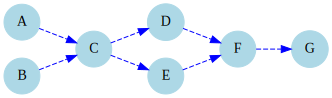

In [15]:
def connect_dot(node):
    dot = Digraph(format='png', graph_attr={'rankdir': 'LR'})

    nodes, edges = trace_routes(node)

    for node in nodes:
        dot.node(name=str(id(node)),label=node.label, shape='circle', style='filled', color='lightblue')
    #end-for

    for child, parent in edges:
        dot.edge(str(id(child)), str(id(parent)), color='blue', style='dashed')
    #end-for

    return dot #dot.render('./Karpathy_Networks/sample_Graph', view=True)
#end-for

dot = connect_dot(G)
# print(dot)

dot # dot.render('./Karpathy_Networks/sample_Graph', view=True)

In [16]:
class Value:
    def __init__(self, data, _children=[], _operation='', label=''):
        self.data = data
        self.grad = 0.0    # No effect when an instance (=object) has been just created.
        self.velocity = 0.0
        self.label = label

        # These are for backprop.
        self._children = _children
        self._operation = _operation
        self._backward = lambda: None # blank function.
        '''
        • The left nodes cannot call not  _backward method.
        • It is an empty function when an instance (=object) has just been created.
        • "def v(): None" and "v = lambda: None" represent exactly same function.
        '''
    #end-def

    def __repr__(self,):
        return f'Value(data={self.data:0.4f}, grad={self.grad:0.4f}, label={self.label})'
    #end-def

    def __add__(self, other):
        '''
        • Operation: When we ask to calculate "a+b," 
        Python internally calls "a.__add__(b)."
        '''
        other = other if isinstance(other, Value) else Value(data=other)
        
        output = Value(data=self.data + other.data,
                     _children=[self, other],
                     _operation='+')

        def _backward():
            self.grad  += 1.0 * output.grad
            other.grad += 1.0 * output.grad
        #end-def
        output._backward = _backward
        # This should not be _backward(); otherwise, it calls each time.
        return output
    #end-def

    def __radd__(self, other):
        return self + other
    #end-def

    def __mul__(self, other):
        '''
        Operation: When we ask to calculate "a*b," 
        Python internally calls "a.__mul__(b)."
        '''
        other = other if isinstance(other, Value) else Value(data=other)

        output = Value(data=self.data * other.data,
                     _children=[self, other],
                     _operation='*')
        
        def _backward():
            self.grad  += other.data * output.grad
            other.grad += self.data  * output.grad

            # print(f'''
            #     self.data: {self.data}, self.grad: {self.grad},
            #     other.data: {other.data}, self.grad: {other.grad}, 
            #     output.data: {output.data}, output.grad {output.grad}
            # ''')
        #end-def
        output._backward = _backward
        # This should not be _backward(); otherwise, it calls each time.
        return output
    #end-def

    def __rmul__(self, other):
        return self * other
    #end-def

    def __neg__(self):
        return self * (-1.0)
    #end-def

    def __sub__(self, other):
        return self + (-other)
    #end-def

    def __rsub__(self, other):
        return (-self) + other
    #end-def

    def __pow__(self, other):
        assert isinstance(other, (int, float)), '__pow__ supports solely int and float.'
        
        output = Value(self.data ** other, _children=[self,], _operation=f'{self.data}^{other}')

        def _backward():
            self.grad += (other * (self.data ** (other - 1.0))) * output.grad
        #end-def
        output._backward = _backward
        
        return output
    #end-def

    def __truediv__(self, other):
        # z = a(=2) / 2.5 = 0.8
        return self * (other ** (-1.0))
    #end-def

    def __rtruediv__(self, other):
        # z = 2.5 / a(=2) = 1.25
        return (self**(-1.0)) * other

    def tanh(self):
        x = self.data
        
        # exponent_portion = math.exp(2.0*x) # exponet_portion = (2.0*x).exp()

        # data = (exponent_portion - 1) / (exponent_portion + 1)

        data = math.tanh(x)

        output = Value(data=data, _children=[self], _operation='tanh( )')
        
        def _backward():
            self.grad += (1.0-(output.data**2.0)) * output.grad
        #end-def
        output._backward = _backward

        return output
    #end-def

    def relu(self):
        x = self.data
        output = Value(data=x if x>0 else 0.0, _children=[self,], _operation='ReLU( )')
        
        def _backward():
            self.grad += (1.0 if x>0 else 0.0) * output.grad
        #end-def
        output._backward = _backward
        
        return output
    #end-def

    def log(self):
        output = Value(data=math.log(self.data), _children=[self,], _operation='logₑ( )')
        
        def _backward():
            self.grad += (1.0/self.data) * output.grad
        #end-def
        output._backward = _backward
        
        return output
    #end-def

    def sigmoid(self):
        x = self.data
        
        sigmoid = 1.0 / (1.0 + math.exp(-x))

        output = Value(data=sigmoid, _children=[self,], _operation='sigmoid( )')

        def _backward():
            self.grad += (sigmoid * (1.0 - sigmoid)) * output.grad
        #end-def

        output._backward = _backward
        return output
    #end-def

    def exp(self,):
        x = math.exp(self.data)
        output = Value(data=x, _children=[self,], _operation='exp( )')

        def _backward():
            self.grad += x * output.grad
        #end-def
        output._backward = _backward
        return output
    #end-def

    def backward(self):
        ordered_topology = []
        visited_nodes = []

        def build_topology(node):
            if node not in visited_nodes:
                visited_nodes.append(node)

                # children = node._children
                # child = 0
                # while child<len(children):
                #     build_topology(children[child])
                #     child += 1
                # #end-while

                for child in node._children:
                    build_topology(child)
                #end-for
                
                ordered_topology.append(node)
            #end-if/else
        #end-def
        build_topology(self)

        self.grad = 1.0
        for node in reversed(ordered_topology):
            node._backward()
        #end-def
    #end-def
#end-def

In [ ]:
def trace_routes(node):
    nodes = []
    edges = []

    def build(node):
        if node not in nodes:
            nodes.append(node)
            for child in node._children:
                edges.append((child, node)) # u --> v
                build(child)
            #end-for
        #end-if/else
    #end-def
    build(node)

    return nodes, edges
#end-def

# nodes, edges = trace_routes(z)



# def connect_dot(root):
#     dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

#     nodes, edges = trace_routes(root)
    
#     # print(edges)

#     for node in nodes:
#         print(node)

#     for node in nodes:
#         uid = str(id(node))
#         dot.node(name = uid, label = f'{node.label} | data = {node.data:.4f} | grad = {node.grad:.4f}', shape='record')
        
#         if node._operation:
#             dot.node(name = uid + node._operation, label = node._operation)
#             dot.edge(uid + node._operation, uid)
#         #end-else/if
#     #end-for

#     for node1, node2 in edges:
#         dot.edge(str(id(node1)), str(id(node2)) + node2._operation)
#     #end-for

#     return dot
# #end-def

[(Value(data=-2.5000, grad=0.0000, label=a), Value(data=2.0000, grad=0.0000, label=z)), (Value(data=4.5000, grad=0.0000, label=b), Value(data=2.0000, grad=0.0000, label=z))]


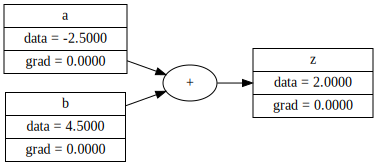

In [102]:
a = Value(-2.5, label='a')
b = Value(4.5, label='b')

z = a + b
z.label = 'z'

nodes, edges = trace_routes(z)

# z = a.tanh()

# print(z)
# z.backward()

# connect_dot(z)

dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

for node in nodes:
    uid = str(id(node))
    dot.node(name = uid, label = f'{node.label} | data = {node.data:.4f} | grad = {node.grad:.4f}', shape='record')

    if node._operation:
        dot.node(name = uid + node._operation, label = node._operation)
        dot.edge(uid + node._operation, uid)
    #end-else/if
#end-for

dot

print(edges)


for node1, node2 in edges:
    dot.edge(str(id(node1)), str(id(node2))+node2._operation)
#end-for

dot